# Compare Colors Auxtel Photometric data and Pickles SED in Auxtel filters (SDSS prime)

- author Sylvie Dagoret-Campagne
- creation date : 2024/08/01
- update : 2024/08/01
- last update : 2024/09/02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/sylvie/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

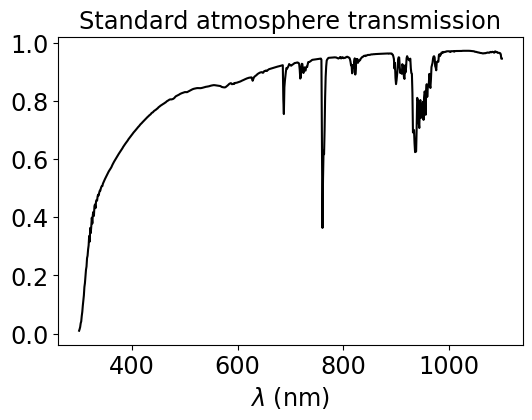

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

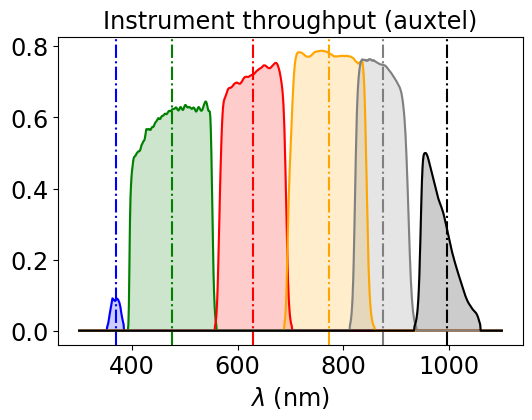

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

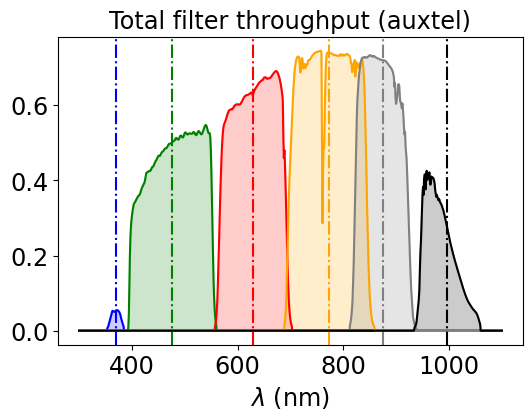

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

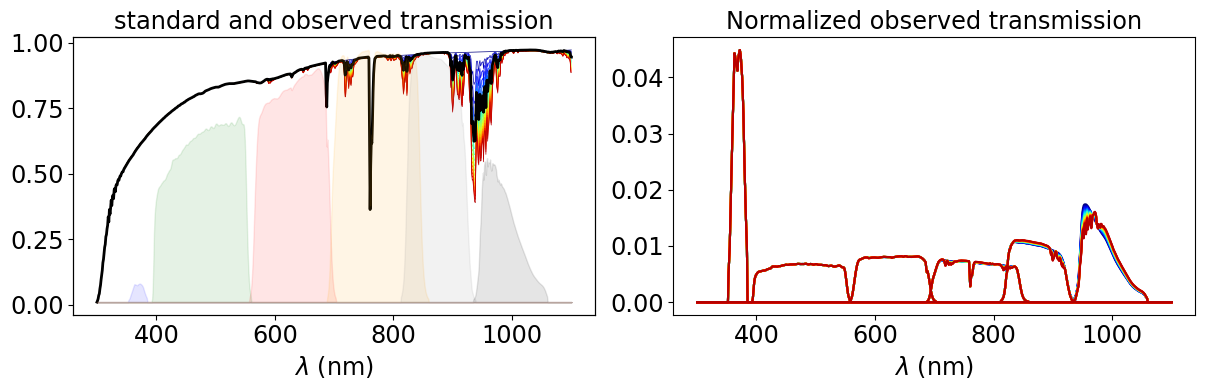

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## SED

In [20]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [21]:
seddir = os.path.join(fdir, 'pysynphot', 'pickles')

In [22]:
seddir_uvi = os.path.join(seddir,"dat_uvi")
seddir_uvk = os.path.join(seddir,"dat_uvk")

In [23]:
all_pickles_uvi = sorted(os.listdir(seddir_uvi))
all_pickles_uvk = sorted(os.listdir(seddir_uvk))

In [24]:
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")

In [25]:
hdul = fits.open(file_ref)

In [26]:
df_pickle = pd.DataFrame(hdul[1].data)

In [27]:
df_pickle

,FILENAME,SPTYPE
0,pickles_uk_1,O5V
1,pickles_uk_2,O9V
2,pickles_uk_3,B0V
3,pickles_uk_4,B1V
4,pickles_uk_5,B3V
...,...,...
126,pickles_uk_127,G8I
127,pickles_uk_128,K2I
128,pickles_uk_129,K3I
129,pickles_uk_130,K4I


In [28]:
NSED = len(df_pickle)

In [29]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_21994/1274266691.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels(labels,rotation=45);
/Users/sylvie/mambaforge/envs/mamba_py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


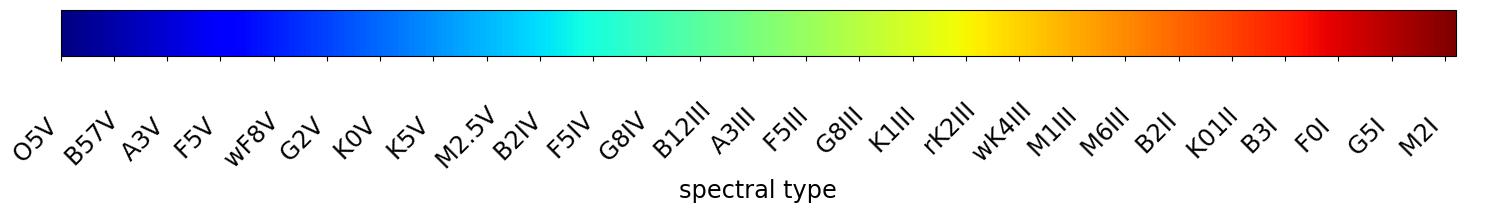

In [30]:
fig, ax = plt.subplots(figsize=(18, 0.6), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=NSED)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='spectral type')

# change the number of labels
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
cbar.ax.locator_params(axis='x', nbins=4*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]

# rename the labels
Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_xticklabels(labels,rotation=45);
plt.show()

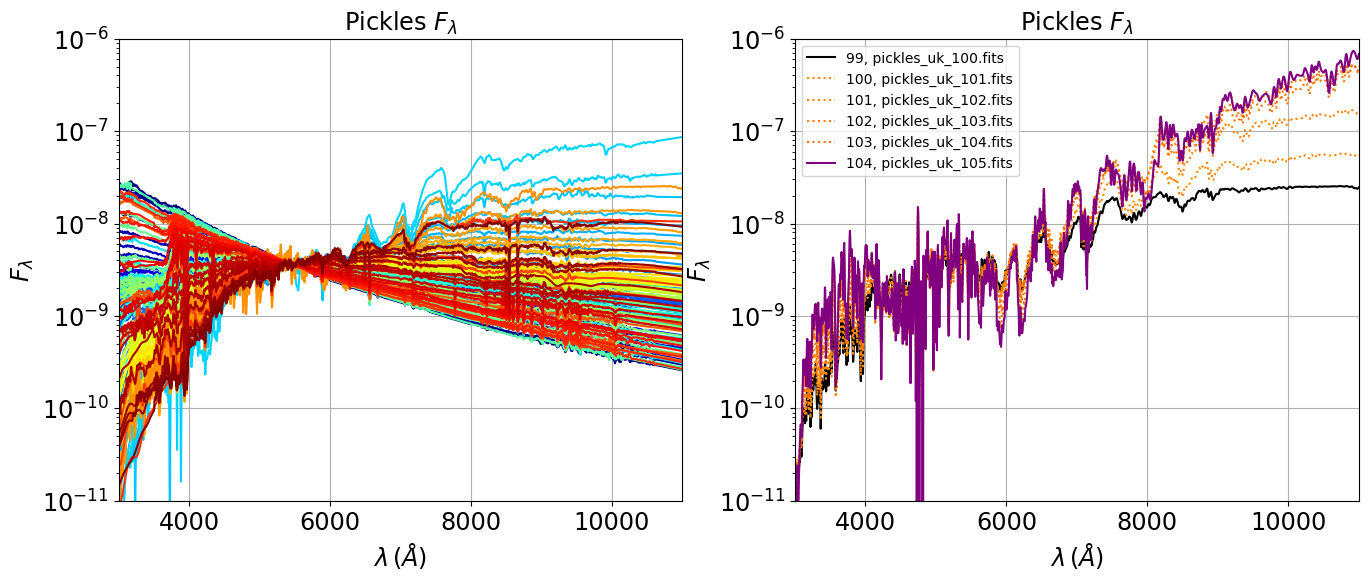

In [31]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,6))
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    #if index <= 103 or index >= 105:
    if index < 100 or index > 104:    
        ax.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
ax.set_yscale('log')
ax.set_xlim(3000.,11000)
ax.set_ylim(1e-11,1e-6)
ax.grid()
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")
#plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
#ax.collections[-1].colorbar

for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    label= f"{index}, {filename}"
    #if index <= 103 or index >= 105:
    if index >= 99 and index <= 104: 
        if index == 99:
            ax2.plot(dff.WAVELENGTH,dff.FLUX,color="k",label=label)
        elif index == 104:
            ax2.plot(dff.WAVELENGTH,dff.FLUX,color="purple",label=label)
        else:
            ax2.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index],ls=":",label=label)
ax2.set_yscale('log')
ax2.set_xlim(3000.,11000)
ax2.set_ylim(1e-11,1e-6)
ax2.grid()
ax2.set_title("Pickles $F_\lambda$")
ax2.set_ylabel("$F_\lambda$")
ax2.set_xlabel("$\lambda \, (\AA$)")
ax2.legend()

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_21994/55984639.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels,rotation=0);


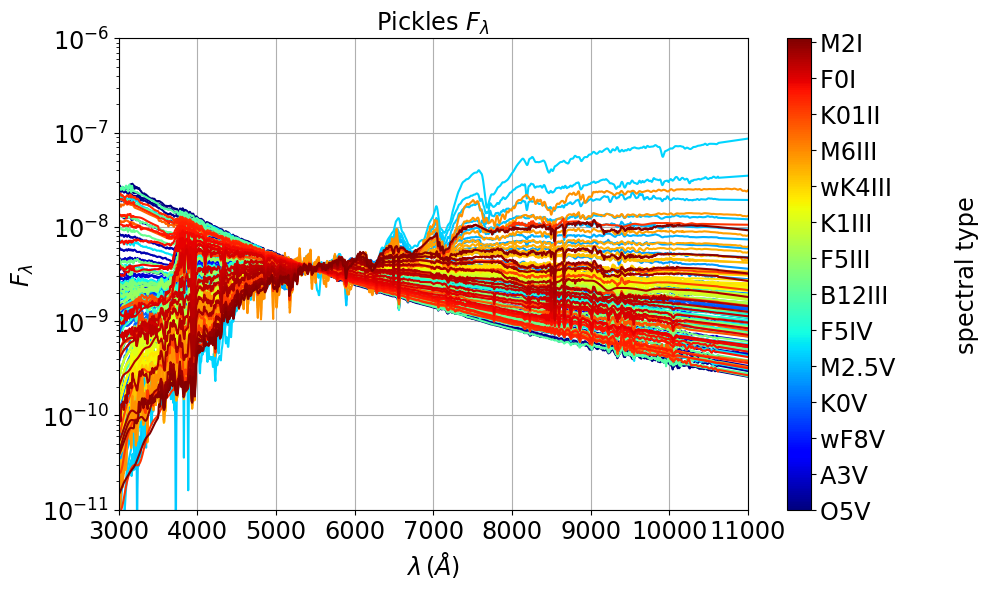

In [38]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    #if index <= 103 or index >= 105:
    if index < 100 or index > 104:    
        ax.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
ax.set_yscale('log')
ax.set_xlim(3000.,11000)
ax.set_ylim(1e-11,1e-6)
ax.grid()
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")

#cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax)
cbar =fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical', label='spectral type')

#cbar = plt.colorbar(ax.collections[0],ax=ax)
#cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_yticklabels(labels,rotation=0);
plt.tight_layout()

In [ ]:
# rename the labels
Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_xticklabels(labels,rotation=45);

In [ ]:
len(ax.collections)

## Convert SED in rubinsim format

In [ ]:
all_sed = []
zmag = 20.0
for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    wl= dff.WAVELENGTH.values
    flux = dff.FLUX.values
    #wavelen (nm)
    #flambda (ergs/cm^2/s/nm)
    the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
    the_sed.multiply_flux_norm(flux_norm)
    all_sed.append(the_sed) 

### Check the calculation of the Magnitude and the ADC counts (observation)

In [ ]:
the_sed1 = all_sed[0]
flux_norm = the_sed1.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
the_sed1.multiply_flux_norm(flux_norm)

the_sed2 = all_sed[-1]
flux_norm = the_sed2.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
the_sed2.multiply_flux_norm(flux_norm)

In [ ]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,6))
ax.plot(the_sed1 .wavelen,the_sed1 .flambda,"b-",label=the_sed1.name)
ax.plot(the_sed2.wavelen,the_sed2.flambda,"r-",label=the_sed2.name)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-17,1e-14)
ax.set_xlim(300.,2000.)
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")


ax2.plot(the_sed1 .wavelen,the_sed1.fnu,"b-",label=the_sed1.name)
ax2.plot(the_sed2.wavelen,the_sed2.fnu,"r-",label=the_sed2.name)
ax2.set_yscale("log")
ax2.legend()
ax2.set_ylim(1e-7,1e-3)
ax2.set_xlim(300.,2000.)
ax2.set_title("Pickles $F_\\nu$")
ax2.set_ylabel("$F_\\nu$")
ax2.set_xlabel("$\lambda \, (\AA$)")

ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])
    
ax4 = ax2.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax4.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax4.set_yticks([])

In [ ]:
mags_std1 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std1[f] = the_sed1.calc_mag(pc.bandpass_total_std[f])
mags_std1["g-r"] = mags_std1["g"]- mags_std1["r"]  
mags_std1["z-y"] = mags_std1["z"]- mags_std1["y"]   
df1 = pd.DataFrame(mags_std1, index=[the_sed1.name]).T

mags_std2 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std2[f] = the_sed2.calc_mag(pc.bandpass_total_std[f])
mags_std2["g-r"] = mags_std2["g"]- mags_std2["r"]  
mags_std2["z-y"] = mags_std2["z"]- mags_std2["y"]   
df2 = pd.DataFrame(mags_std2, index=[the_sed2.name]).T
dfa =pd.concat([df1,df2],axis=1)
dfa

In [ ]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_stdmag1 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag1[f] = -2.5*np.log10(the_sed1.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag1["g-r"] = adcs_stdmag1["g"]- adcs_stdmag1["r"]  
adcs_stdmag1["z-y"] = adcs_stdmag1["z"]- adcs_stdmag1["y"]      
df1 = pd.DataFrame(adcs_stdmag1, index=[the_sed1.name]).T

adcs_stdmag2 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag2[f] = -2.5*np.log10(the_sed2.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag2["g-r"] = adcs_stdmag2["g"]- adcs_stdmag2["r"]  
adcs_stdmag2["z-y"] = adcs_stdmag2["z"]- adcs_stdmag2["y"]      
df2 = pd.DataFrame(adcs_stdmag2, index=[the_sed2.name]).T

dfb =pd.concat([df1,df2],axis=1)
dfb

## Get the data

In [ ]:
df_data = pd.read_csv("isolated_objects_magandcolors_psfap_good.csv",index_col=0)

In [ ]:
df_data.head() 

## Generate dataframe with magnitudes

In [ ]:
df_out = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                 "aduu","adug","adur","adui","aduz","aduy"])
mags_std = {}
adcs_stdmag = {}

for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    the_sed = all_sed[index] 
    for index2,f in enumerate(filter_tagnames) :
        mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
    df_out.loc[index] = [ index,filename, spectype ,
                    mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                    adcs_stdmag["u"],adcs_stdmag["g"],adcs_stdmag["r"],adcs_stdmag["i"],adcs_stdmag["z"],adcs_stdmag["y"]]
                                

## Selections of good spectra

In [ ]:
df_out = df_out[df_out.index != 104]
#df_out = df_out[(df_out.index < 99) | (df_out.index > 103)]
#df_out.reset_index(drop=True, inplace=True)

In [ ]:
df_out["magG_R"] = df_out["magg"] - df_out["magr"]
df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
df_out["aduG_R"] = df_out["adug"] - df_out["adur"]
df_out["aduZ_Y"] = df_out["aduz"] - df_out["aduy"]

In [ ]:
df_out

In [ ]:
df_out.spectype.values

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (obs ADU mag) of Pickles stars")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")
ax.set_aspect("equal")
ax.errorbar(df_data["z_y_ap"],df_data["g_r_ap"],xerr=df_data["sig_z_y_ap"] , yerr=df_data["sig_g_r_ap"], fmt="o",color='k',ecolor="grey",label="Auxtel data")

ax.legend()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(14,8))
df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (obs ADU mag) of Pickles stars")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")
ax.set_xlim(-2.0,-0.5)
ax.set_ylim(-1.0,1.8)

ax.set_aspect("equal")


ax.errorbar(df_data["z_y_ap"],df_data["g_r_ap"],xerr=df_data["sig_z_y_ap"] , yerr=df_data["sig_g_r_ap"], fmt="o",facecolor=None,color='k',ecolor="grey",label="Auxtel data")
ax.legend()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (calib AB mag) for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")
ax.set_aspect("equal")

ax.errorbar(df_data["z_y_psf"],df_data["g_r_psf"],xerr=df_data["sig_z_y_psf"] , yerr=df_data["sig_g_r_psf"], fmt="o",color='k',ecolor="grey",label="Auxtel data")
ax.legend()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(14,8))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (calib AB mag) for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")
ax.set_aspect("equal")

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1.0,2.)


ax.errorbar(df_data["z_y_psf"],df_data["g_r_psf"],xerr=df_data["sig_z_y_psf"] , yerr=df_data["sig_g_r_psf"], fmt="o",color='k',ecolor="grey",label="Auxtel data")
ax.legend()